# Get transients given a skymap

- Calculate skymap volume. Calculate the fraction of total surface area covered by a given pixel, and multiply that fraction by the volume of a sphere with radius 1000 Mpc

- Use rates from literature to draw a sample of transients given the skymap volume


In progress:

- fix ra/dec

In [103]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import healpy as hp
from io import BytesIO
import os
import random

from astropy.time import Time
from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
import astropy_healpix as ah
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy.io import fits
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from ligo.skymap.postprocess.cosmology import dVC_dVL_for_DL
import astropy.cosmology as cos
from astropy.cosmology import Planck15 as cosmo, z_at_value

In [2]:
# load skymaps from local directory

def load_skymap_fits(filename, directory):
    filepath = os.path.join(directory, filename)
    with fits.open(filepath) as hdul:
        table = Table.read(hdul)
        return table
    
# load simulated skymaps    
directory = 'skymaps/nsbh_allsky/'
skymap_sim = [load_skymap_fits(file, directory) for file in os.listdir(directory) if file.endswith('.fits')]
names_sim = [os.path.splitext(file)[0] for file in os.listdir(directory) if file.endswith('.fits')]

# load gracedb skymaps
directory = 'skymaps/gracedb/'
skymap_gracedb = [load_skymap_fits(file, directory) for file in os.listdir(directory) if file.endswith('.fits')]
names_gracedb = [os.path.splitext(file)[0] for file in os.listdir(directory) if file.endswith('.fits')]

In [3]:
# adapted from https://github.com/lpsinger/ligo.skymap/blob/a8da314dcb078f7866f4178cbd523b9844cceae0/ligo/skymap/postprocess/crossmatch.py

def get_skymap_voxels(skymap, name, contour=0.9, cosmology=True):
    """
    Determine the volume per pixel in the 90% region out to a distance of 1000Mpc for a skymap
    This volume is associated with a sky position and can be used with positionally nonuniform rates
    """
    # get specified countour of skymap, drop other pixels
    skymap.sort('PROBDENSITY', reverse = True)
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ']) # ipix = sky location
    nside = ah.level_to_nside(level) # nside = multi-order pixel resolution
    pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # pixel area in steradians
    prob = pixel_area * skymap['PROBDENSITY']
    cumprob = np.cumsum(prob)
    i = cumprob.searchsorted(contour)
    dA_sr = pixel_area[:i]

    #verifying that contour is correct
    #dA_deg2 = dA_sr.to(u.deg**2)
    #print(f'Sum of pixel areas in square degrees: {sum(dA_deg2)}')

    # My Voxel calc - multiply volume of sphere radius 1000Mpc by fraction of pixel steradians / 4pi steradians in a sphere
    r = 1000 #Mpc
    dV = 4/3 * np.pi * r**3 * dA_sr.reshape(-1, 1)/(4 * np.pi * u.sr) #euclidean volume

    # convert euclidean to comving volume
    if cosmology:
        dV *= dVC_dVL_for_DL(r)
    
    #for CVs get pixels that are within 10 degrees of the galactic plane (replace 10 with correct value)
    ra, dec = ah.healpix_to_lonlat(ipix[:i], nside[:i])
    sky_coords = SkyCoord(ra=ra, dec=dec, frame='icrs')
    galactic_coords = sky_coords.galactic
    dV_CV = [v for v, coords in zip(dV, galactic_coords) if np.abs(coords.l.deg) < 10]

    V = np.sum(dV)
    print(f'{name} has total volume: {round(int(V))} Mpc3') 

    return V, dV, dV_CV

In [4]:
voxels_gracedb = [get_skymap_voxels(data, name) for data,name in zip(skymap_gracedb, names_gracedb)]

S230518h has total volume: 23146839 Mpc3
S230731an has total volume: 30102502 Mpc3
S231113bw has total volume: 86159440 Mpc3
S230529ay has total volume: 1234160364 Mpc3
S230627c has total volume: 4097930 Mpc3


In [5]:
# check euclidean volumes to validate assumption comoving volume is necessary at these redshifts

voxels__gracedb_euc = [get_skymap_voxels(data, name, cosmology=False) for data,name in zip(skymap_gracedb, names_gracedb)]

S230518h has total volume: 46722498 Mpc3
S230731an has total volume: 60762683 Mpc3
S231113bw has total volume: 173915071 Mpc3
S230529ay has total volume: 2491184799 Mpc3
S230627c has total volume: 8271778 Mpc3


In [6]:
voxels_sim = [get_skymap_voxels(data, name) for data,name in zip(skymap_sim, names_sim)]

14 has total volume: 353968271 Mpc3
60 has total volume: 10364886 Mpc3


In [7]:
# combine event info to more easily access

events_gracedb = [[name, skymap, voxel] for name, skymap, voxel in zip(names_gracedb, skymap_gracedb, voxels_gracedb)]
events_sim = [[name, skymap, voxel] for name, skymap, voxel in zip(names_sim, skymap_sim, voxels_sim)]

# get rates from volumes

In [8]:
transient_rates = {
    'SNIa': 2.35e4,  # per Gpc^3 per year
    'CCSN': 1.01e5,
    'SLSN': 5.6,
    'KN': 5e3,
    'GRB_on_axis': 1,
    'GRB_off_axis': 7,
    'CV': 1e6,  # Use a refined rate near the galactic plane
}

In [37]:
# probability density function for radii of events evenly distributed in sphere w/ r=1000Mpc
def pdf_radii(num_events, sphere_radius = 1000):
    """
    Sample radii for events evenly distributed in a sphere.
    """
    radius_z = cos.z_at_value(cosmo.luminosity_distance, sphere_radius * u.Mpc, method = 'bounded').value
    uniform = np.random.uniform(0, 1, num_events)
    radii = radius_z * np.cbrt(uniform)  # Inverse transform sampling for r^2 PDF
    return radii

# get ras and decs
def random_ra_dec_skymap(num_events, skymap, contour=0.9):
    """
    Given skymap and number of events, return random ra, dec positions in 90% region
    """
    skymap.sort('PROBDENSITY', reverse = True)
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ']) # ipix = sky location
    nside = ah.level_to_nside(level) # nside = multi-order pixel resolution
    pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # pixel area in steradians
    prob = pixel_area * skymap['PROBDENSITY']
    cumprob = np.cumsum(prob)
    i = cumprob.searchsorted(contour)

    #get ra and dec in degrees associated with each pixel
    #current approach: randomly select pixel coords and randomly add displacements (pixels should range 6.9' to 1.7" per pixel)
    select_pixel = np.random.choice(range(i), num_events)
    ra, dec = ah.healpix_to_lonlat(ipix[select_pixel], nside[select_pixel])
    #select from whole skymap region rather than discrete pixel values
    # attempt to randomly offset selected ra/dec within the pixel - this is a fudged solution but good enough?
    select_pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level[select_pixel]))
    pix_offset = np.sqrt(select_pixel_area.to(u.deg**2)) / 2 
    ra_deg = ra.deg + np.random.uniform(-pix_offset,pix_offset)
    dec_deg = dec.deg + np.random.uniform(-pix_offset,pix_offset)
    return ra_deg, dec_deg

# get rates for each transient given a skymap
# Note: if for example num_events = 0.5, half the time 1 event will be generated, half the time 0 events will be generated
def get_rates(literature_rates, voxel, name, time_window=7, verbose=True):
    num_events = []
    for transient, rate in literature_rates.items():
        if transient != 'CV':
            volume = voxel[0] * 10**-9 # convert to Gpc^3
            events = rate * volume * time_window / 365.25
        else:
            volume = np.sum(voxel[2]) * 10**-9 # convert to Gpc^3
            events = rate * volume * time_window / 365.25
        # Handle the decimal part probabilistically
        integer_part = int(events)
        decimal_part = events - integer_part
        if random.random() <= decimal_part:
            events = integer_part + 1
        else:
            events = integer_part
        num_events.append(events)

    if verbose:
        print(name)
        for item1, item2 in zip(list(literature_rates.keys()), num_events):
            print(f"{item1} : {item2}")
    return num_events

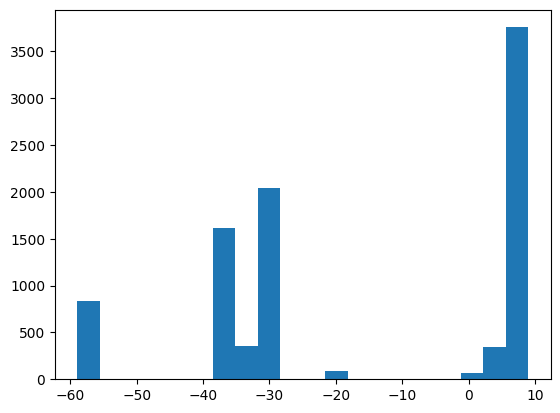

In [90]:
# problem to address: the decs in the 90% region of the skymap seem to be clustered around 3 values, something is wrong...
skymap = events_gracedb[0][1]
skymap.sort('PROBDENSITY', reverse = True)
level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ']) # ipix = sky location
nside = ah.level_to_nside(level) # nside = multi-order pixel resolution
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # pixel area in steradians
prob = pixel_area * skymap['PROBDENSITY']
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.9)
ra, dec = ah.healpix_to_lonlat(ipix[:i], nside[:i])
hist = plt.hist(dec.deg, bins=20)
plt.show()

In [73]:
rates_gracedb = [get_rates(transient_rates, voxel=event[2], name=event[0], time_window=7) for event in events_gracedb]

S230518h
SNIa : 10
CCSN : 45
SLSN : 0
KN : 2
GRB_on_axis : 0
GRB_off_axis : 0
CV : 29
S230731an
SNIa : 13
CCSN : 58
SLSN : 0
KN : 2
GRB_on_axis : 0
GRB_off_axis : 0
CV : 18
S231113bw
SNIa : 39
CCSN : 167
SLSN : 0
KN : 8
GRB_on_axis : 0
GRB_off_axis : 0
CV : 87
S230529ay
SNIa : 556
CCSN : 2388
SLSN : 0
KN : 118
GRB_on_axis : 0
GRB_off_axis : 0
CV : 429
S230627c
SNIa : 2
CCSN : 8
SLSN : 0
KN : 0
GRB_on_axis : 0
GRB_off_axis : 0
CV : 0


In [40]:
rates_sim = [get_rates(transient_rates, voxel=event[2], name=event[0], time_window=7) for event in events_sim]

14
SNIa : 159
CCSN : 685
SLSN : 0
KN : 34
GRB_on_axis : 0
GRB_off_axis : 0
CV : 350
60
SNIa : 5
CCSN : 20
SLSN : 0
KN : 1
GRB_on_axis : 0
GRB_off_axis : 0
CV : 4


In [41]:
def get_transients(literature_rates,event,time_window=7):
    """
    get sample of transients 
    
    Parameters:
    transient_rates: dictionary of transient types and rates in Gpc^3 / year
    voxels: list of tuples containing volume, volume per pixel, ra, dec for a given skymap
    skymap: table containing skymap data
    time_window: time window in days to calculate expected transients

    returns: 
    number of expected transients for each transient type, with sampled ra, dec, and distance (change this to redshift)
    """

    # get number of events for each transient type  
    voxel=event[2]
    name=event[0]
    num_events = get_rates(literature_rates, voxel=voxel, name=name, time_window=time_window, verbose=False)

    # sample ra and dec for each transient type
    skymap=event[1]
    radec = [random_ra_dec_skymap(num, skymap) for num in num_events]

    # get sample of redshifts from sphere with radius 1000Mpc
    z = [pdf_radii(num) for num in num_events]

    # get start times for each transient MJD
    gw_time = skymap.meta['DATE-OBS']
    gw_mjd = round(Time(gw_time, format='fits').mjd) 
    start_times = [gw_mjd + np.random.uniform(0, time_window, num) for num in num_events]

    return(num_events, radec, z, start_times)

In [42]:
# test with one gracedb event
test = events_gracedb[0]
print(f'transients for {test[0]}')
gracedb_test = get_transients(transient_rates, test)

transients for S230518h


In [43]:
# test with one simulated event

sim_test = get_transients(transient_rates, events_sim[0])

# plot transients

In [106]:
def plot_transients(skymap_url, transients):
    fig = plt.figure(figsize=(12, 9), dpi=100)
    ax = fig.add_subplot(111, projection='astro degrees mollweide')
    ax.grid()
    ax.imshow_hpx(skymap_url, cmap='cylon')
    
    coords = transients[1]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#e377c2', '#8c564b']
    labels = [f'{len(coords[0][0])} SNIa', f'{len(coords[1][0])} CCSN', f'{len(coords[2][0])} SLSN', 
              f'{len(coords[3][0])} KN', f'{len(coords[4][0])} GRB_on_axis', f'{len(coords[5][0])} GRB_off_axis', f'{len(coords[6][0])} CV']
    
    scatter_handles = []
    for coord, color, label in zip(coords, colors, labels):
        if len(coord[0]) > 0:
            scatter = ax.scatter(coord[0], coord[1], transform=ax.get_transform('icrs'), s=20, color=color, label=label)
            scatter_handles.append(scatter)
    
    legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=7, label=label) for color, label in zip(colors, labels)]
    ax.legend(handles=legend_handles, loc='upper right')
    
    plt.show()

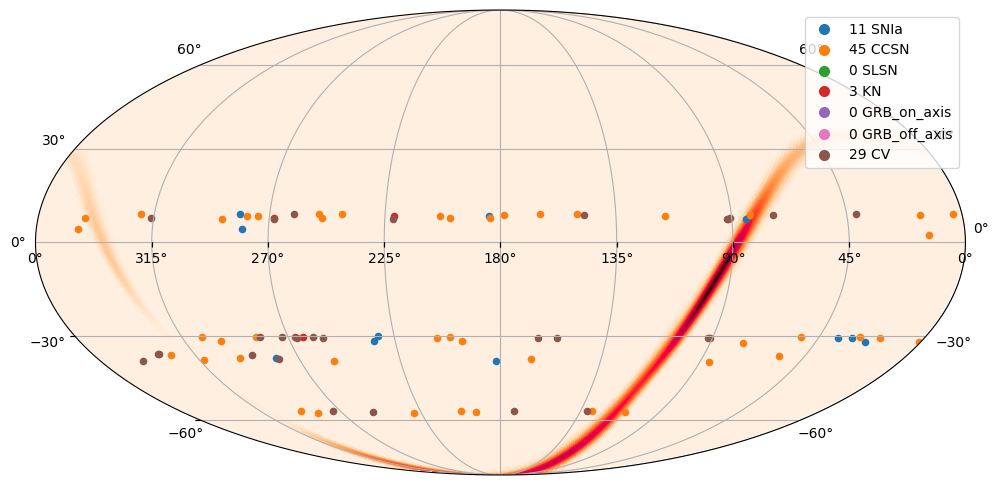

In [107]:
url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
transients = gracedb_test

plot = plot_transients(url, transients)